# **Libraries**

In [ ]:
!pip install -U -q PyDrive

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import shutil
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from keras_preprocessing import image
from shutil import copyfile
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# **Data Imports**
[Corn Dataset](https://www.kaggle.com/datasets/soumiknafiul/plantvillage-dataset-labeled?select=PlantVillage+Dataset+%28Labeled%29)

The dataset is from kaggle "PlantVillage" for project purpose we modified the dataset, just only have "Corn/Maize" class.

Link for dataset in Google Drive
https://drive.google.com/file/d/1Z_3m27txFNG5uxVSalnbxJFy6kZc7FSa/view?usp=sharing

## **Google Drive Authentication**

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1Z_3m27txFNG5uxVSalnbxJFy6kZc7FSa/view?usp=sharing'

In [ ]:
id = link.split('d/')[1].split('/view?')[0]
print (id)

1Z_3m27txFNG5uxVSalnbxJFy6kZc7FSa


## **Download and Unzip Files**

In [ ]:
drive_file = drive.CreateFile({'id':id})  
drive_file.GetContentFile('Plant-Village-Corn.zip')

In [ ]:
file_zip = 'Plant-Village-Corn.zip'
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall('content/Plant-Village-Corn.zip')
zip_ref.close()

print(os.listdir('content/Plant-Village-Corn.zip'))

['Cercospora_Leaf_Spot_Gray_Leaf_Spot', 'Common_Rust', 'Northern_Leaf_Blight', 'Healthy']


# **Exploratory Data Analysis**

In [ ]:
def move_image(src_dir, classname_list, destination_root_dir):
  """
  Params:
          src_dir: Root directory of source, enclosed by string
          classname_list : List contains desired name of class(es), ordered alphabetically
          destination_root_dir : Root directory of destination
  """ 
  if not os.path.exists(destination_root_dir):
    os.makedirs(destination_root_dir) 
  class_src = sorted([dirs for root, dirs, files in os.walk(src_dir)][0])
  for index in range(len(classname_list)):
    if os.path.exists(os.path.join(destination_root_dir, str(classname_list[index]))):
      os.makedirs(os.path.join(destination_root_dir, str(classname_list[index])))
    if len(class_src) == len(classname_list):
      shutil.copytree(os.path.join(src_dir, str(class_src[index])),
                      os.path.join(destination_root_dir, str(classname_list[index])))
    else:
      raise Exception("Number of directories not equal between source and destination")

In [ ]:
cornleaf_classname = ['Northern_Leaf_Blight',
                      'Cercospora_Leaf_Spot_Gray_Leaf_Spot',
                      'Common_Rust',
                      'Healthy']

src_dir = ('content/Plant-Village-Corn.zip')
root_dir = '/tmp/Data'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

move_image(src_dir, cornleaf_classname, root_dir)

In [ ]:
def simple_eda(data_dir):
  """
  Params:
              
  """ 
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  class_num = len(class_list)
  print("There are {} classes with various number of images for each".format(class_num))

  images_num = []
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    images_num.append(len(os.listdir(class_dir)))
    print("\n - {} : {} images".format(each_class, len(os.listdir(class_dir))))

  plt.figure(figsize=(8, 6))
  ax = plt.subplot()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  plt.bar(class_list, images_num, zorder=3)
  plt.grid(zorder=0)
  plt.title("Images Distribution", fontsize=20)
  plt.xlabel("Classes/Categories", fontsize=12)
  plt.show()

def display_sample(data_dir, num_sample):
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    plt.figure(figsize=(100/num_sample, 4))
    print("\nLabel: {}".format(each_class))
    for index, image_path in enumerate(os.listdir(class_dir)[:num_sample]):
        ax = plt.subplot(1, num_sample, index+1)
        image = mpimg.imread(os.path.join(class_dir, image_path))
        ax.grid()
        plt.imshow(image)
    plt.show()

There are 4 classes with various number of images for each

 - Cercospora_Leaf_Spot_Gray_Leaf_Spot : 1186 images

 - Common_Rust : 1162 images

 - Healthy : 978 images

 - Northern_Leaf_Blight : 513 images


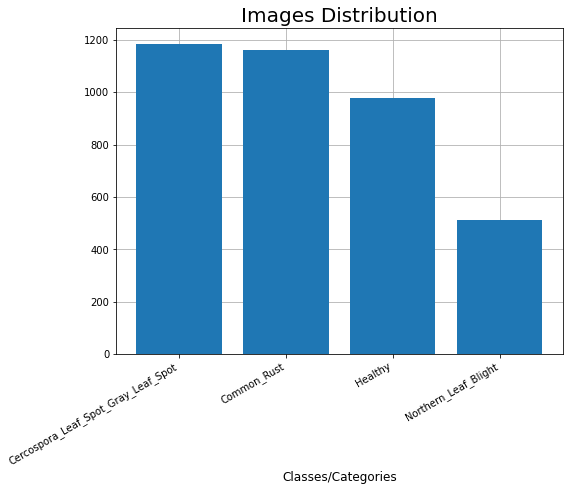

In [ ]:
simple_eda(root_dir)


Label: Cercospora_Leaf_Spot_Gray_Leaf_Spot


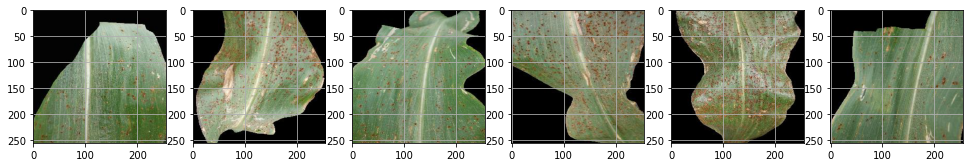


Label: Common_Rust


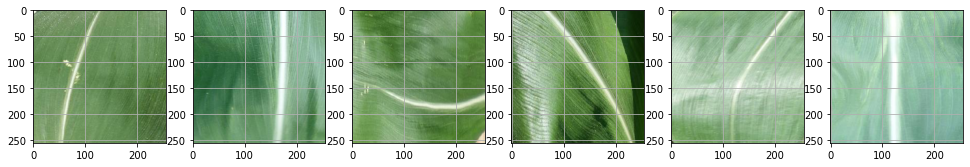


Label: Healthy


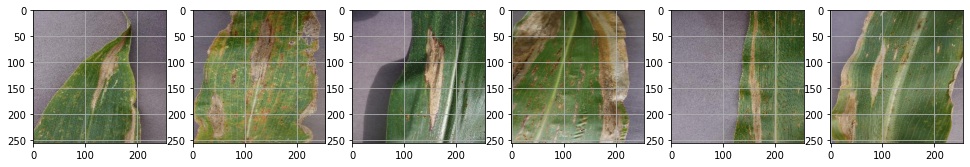


Label: Northern_Leaf_Blight


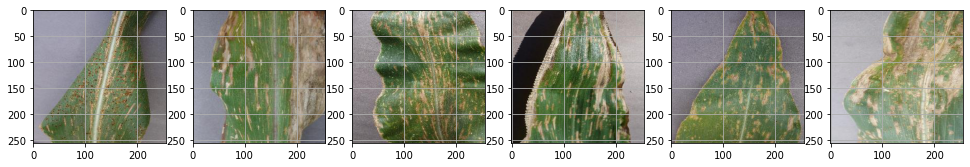

In [ ]:
display_sample(root_dir, num_sample=6)

# **Split Dataset**

In [ ]:
def split_class_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  """
  Params:
              
  """ 
  for dir in [TRAINING, VALIDATION, TESTING]:
    if not os.path.exists(dir):
      os.makedirs(dir)

  if SPLIT_SIZE > 1 or SPLIT_SIZE < 0:
    raise Exception('split size should be between 0 and 1')

  train_val_len = int(len(os.listdir(SOURCE)) * SPLIT_SIZE)
  for index, file in enumerate(os.listdir(SOURCE)): 
    if index < train_val_len:
      if index < int(.95 * train_val_len):
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TRAINING)))
      else:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(VALIDATION)))
    else:
      shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TESTING)))

def display_distribution(DIR, split_type=['Train', 'Validation', 'Test']):
  """
  Params:
                  
  """ 
  user_input_type = [split_type]
  type_list = ['Train', 'Validation', 'Test']
  if len(user_input_type) > 1:
    raise Exception("Please choose one type of split")
  if user_input_type[0] not in type_list:
    raise Exception("Please choose a type of split that provided; \'Train\', \'Validation\', or \'Test\'")
  
  print("\n{}".format(user_input_type[0]))
  for dir_class in sorted(os.listdir(DIR)):
    print('{}: {} images'.format(dir_class, len(os.listdir(os.path.join(DIR, dir_class)))))

In [ ]:
root_split_dir = '/tmp/Split'

if os.path.exists(root_split_dir):
  shutil.rmtree(root_split_dir)

train_split_dir = os.path.join(root_split_dir, 'Train')
validation_split_dir = os.path.join(root_split_dir, 'Validation')
test_split_dir = os.path.join(root_split_dir, 'Test')

Cercospora_Leaf_Spot_Gray_Leaf_Spot_train_dir = os.path.join(train_split_dir, cornleaf_classname[0])
Common_Rust_train_dir = os.path.join(train_split_dir, cornleaf_classname[1])
Healthy_train_dir = os.path.join(train_split_dir, cornleaf_classname[2])
Northern_Leaf_Blight_train_dir = os.path.join(train_split_dir, cornleaf_classname[3])

Cercospora_Leaf_Spot_Gray_Leaf_Spot_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[0])
Common_Rust_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[1])
Healthy_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[2])
Northern_Leaf_Blight_validation_dir = os.path.join(validation_split_dir, cornleaf_classname[3])

Cercospora_Leaf_Spot_Gray_Leaf_Spot_test_dir = os.path.join(test_split_dir, cornleaf_classname[0])
Common_Rust_test_dir = os.path.join(test_split_dir, cornleaf_classname[1])
Healthy_test_dir = os.path.join(test_split_dir, cornleaf_classname[2])
Northern_Leaf_Blight_test_dir = os.path.join(test_split_dir, cornleaf_classname[3])

Cercospora_Leaf_Spot_Gray_Leaf_Spot_source_dir = os.path.join(root_dir, cornleaf_classname[0])
Common_Rust_source_dir = os.path.join(root_dir, cornleaf_classname[1])
Healthy_source_dir = os.path.join(root_dir, cornleaf_classname[2])
Northern_Leaf_Blight_source_dir = os.path.join(root_dir, cornleaf_classname[3])

split_size = .999

split_class_data(Cercospora_Leaf_Spot_Gray_Leaf_Spot_source_dir, Cercospora_Leaf_Spot_Gray_Leaf_Spot_train_dir, Cercospora_Leaf_Spot_Gray_Leaf_Spot_validation_dir, Cercospora_Leaf_Spot_Gray_Leaf_Spot_test_dir, split_size)
split_class_data(Common_Rust_source_dir, Common_Rust_train_dir, Common_Rust_validation_dir, Common_Rust_test_dir, split_size)
split_class_data(Healthy_source_dir, Healthy_train_dir, Healthy_validation_dir, Healthy_test_dir, split_size)
split_class_data(Northern_Leaf_Blight_source_dir, Northern_Leaf_Blight_train_dir, Northern_Leaf_Blight_validation_dir, Northern_Leaf_Blight_test_dir, split_size)

print('[Split Distribution]')
display_distribution(train_split_dir, split_type='Train')
display_distribution(validation_split_dir, split_type='Validation')
display_distribution(test_split_dir, split_type='Test')

[Split Distribution]

Train
Cercospora_Leaf_Spot_Gray_Leaf_Spot: 1124 images
Common_Rust: 1102 images
Healthy: 928 images
Northern_Leaf_Blight: 486 images

Validation
Cercospora_Leaf_Spot_Gray_Leaf_Spot: 60 images
Common_Rust: 58 images
Healthy: 49 images
Northern_Leaf_Blight: 26 images

Test
Cercospora_Leaf_Spot_Gray_Leaf_Spot: 2 images
Common_Rust: 2 images
Healthy: 1 images
Northern_Leaf_Blight: 1 images


# **Data Generator and Augmented**

In [ ]:
def display_augmentation(IMG_PATH, ROTATION_RANGE, WIDTH_SHIFT_RANGE, 
                         HEIGHT_SHIFT_RANGE, SHEAR_RANGE, ZOOM_RANGE):
  """
  Params:
          
  """ 
  image = load_img(IMG_PATH)
  image_array = img_to_array(image)
  image_exp = np.expand_dims(image_array, 0)

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=ROTATION_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_rotate = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=WIDTH_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_width_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     height_shift_range=HEIGHT_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_height_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     shear_range=SHEAR_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_shear = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=ZOOM_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_zoom = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_horizontal_flip = batch[0]

  fig = plt.figure(figsize=(10, 7))
  rows = 2
  cols = 4
  augmented_images = [0, image, image_rotate, image_width_shift, image_height_shift, image_shear, image_zoom, image_horizontal_flip]
  plt_title = [0, "Real Image", "Rotation", "Width Shift", "Height Shift", "Shear", "Zoom", "Horizontal Flip"]
  for index in range(len(augmented_images)):
    if index == 0:
      continue
    fig.add_subplot(rows, cols, index)
    plt.imshow(augmented_images[index])
    plt.axis('off')
    plt.title(plt_title[index])

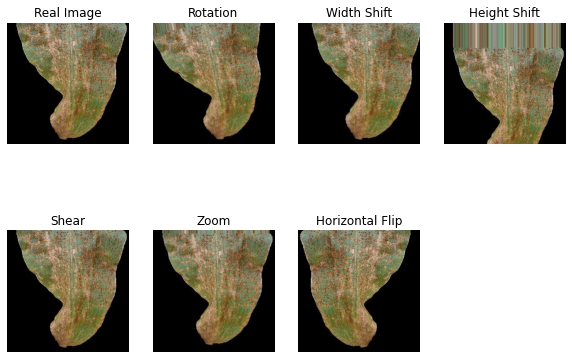

In [ ]:
random_image = random.choice(os.listdir(Common_Rust_train_dir))
rotation_range = 40
width_shift_range = .3
height_shift_range = .3
shear_range = .4
zoom_range = .2
display_augmentation(os.path.join(Common_Rust_train_dir, random_image),
                     rotation_range,
                     width_shift_range,
                     height_shift_range,
                     shear_range,
                     zoom_range)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_split_dir,
    batch_size=11,
    class_mode = 'binary',
    target_size = (300, 300),
    shuffle=True
)



validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

validation_generator = validation_datagen.flow_from_directory(
    validation_split_dir,
    batch_size=4,
    class_mode = 'binary',
    target_size = (300, 300),
    shuffle=True
)

Found 3640 images belonging to 4 classes.
Found 193 images belonging to 4 classes.


In [ ]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [24]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    verbose = 1)

Epoch 1/30
331/331 [==============================] - 406s 1s/step - loss: 0.0000e+00 - accuracy: 0.3036 - val_loss: 0.0000e+00 - val_accuracy: 0.3005
Epoch 2/30
331/331 [==============================] - 406s 1s/step - loss: 0.0000e+00 - accuracy: 0.3047 - val_loss: 0.0000e+00 - val_accuracy: 0.3005
Epoch 3/30
331/331 [==============================] - 404s 1s/step - loss: 0.0000e+00 - accuracy: 0.3047 - val_loss: 0.0000e+00 - val_accuracy: 0.3005
Epoch 4/30
331/331 [==============================] - 405s 1s/step - loss: 0.0000e+00 - accuracy: 0.3049 - val_loss: 0.0000e+00 - val_accuracy: 0.3005
Epoch 5/30
331/331 [==============================] - 406s 1s/step - loss: 0.0000e+00 - accuracy: 0.3044 - val_loss: 0.0000e+00 - val_accuracy: 0.3005
Epoch 6/30
331/331 [==============================] - 406s 1s/step - loss: 0.0000e+00 - accuracy: 0.3058 - val_loss: 0.0000e+00 - val_accuracy: 0.3005
Epoch 7/30
331/331 [==============================] - 406s 1s/step - loss: 0.0000e+00 - accura

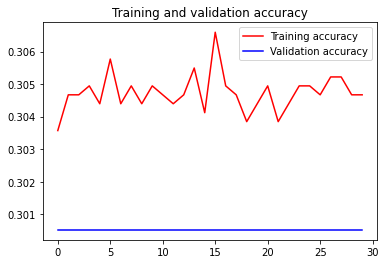

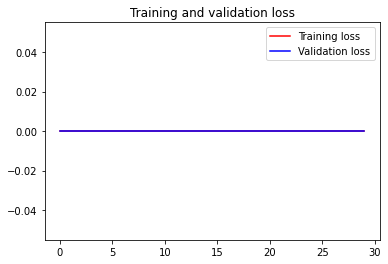

In [27]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot  ( epochs, val_acc, 'b', label='Validation accuracy')
plt.title ('Training and validation accuracy')
# plt.title('Training accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot  ( epochs, val_loss, 'b', label='Validation loss')
plt.title ('Training and validation loss')
# plt.title('Training loss')
plt.legend()

plt.show()